In [185]:
# 测试取样点N的不同初值情况,成功
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import math
import torch
from torch.utils.data import DataLoader

import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
# from torch import vmap
from functorch import vmap, grad
from models import FNN2d, FNN3d
from train_utils import Adam
# from train_utils.datasets import BurgersLoader
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.WaveEq import WaveEq1D, WaveEq2D
from solver.BurgersEq import BurgersEq1D, BurgersEq2D
import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import traceback
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm import tqdm
from train_utils.utils import save_checkpoint, get_grid3d, convert_ic, torch2dgrid, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader2D

from solver.my_random_fields import GRF_Mattern

from importlib import reload
import imageio

try:
    import wandb
except ImportError:
    wandb = None


C:\Users\Sarry\AppData\Local\Temp\ipykernel_19248\806599305.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [186]:
def FDM_Burgers2D(u, D=1, nu=0.01):
    batchsize = u.size(0)
    nx = u.size(1)
    ny = u.size(2)
    nt = u.size(3)
    u = u.reshape(batchsize, nx, ny, nt)
    dt = D / (nt-1)
    dx = D / (nx)
    u2 = u**2
    u_h = torch.fft.fftn(u, dim=[1, 2])
    u2_h = torch.fft.fftn(u2, dim=[1, 2])
    # Wavenumbers in y-direction
    k_max = nx//2
    N = nx
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                     torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(N, 1).repeat(1, N).reshape(1,N,N,1)
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                     torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(1, N).repeat(N, 1).reshape(1,N,N,1)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    uy_h = 2j *np.pi*k_y*u_h
    uyy_h = 2j *np.pi*k_y*uy_h
    u2x_h = 2j *np.pi*k_x*u2_h
    u2y_h = 2j *np.pi*k_y*u2_h
#     ux = torch.fft.irfftn(ux_h[:, :, :k_max+1], dim=[1, 2])
#     uy = torch.fft.irfftn(uy_h[:, :, :k_max+1], dim=[1, 2])
    uxx = torch.fft.irfftn(uxx_h[:, :, :k_max+1], dim=[1, 2])
    uyy = torch.fft.irfftn(uyy_h[:, :, :k_max+1], dim=[1, 2])
    u2x = torch.fft.irfftn(u2x_h[:, :, :k_max+1], dim=[1, 2])
    u2y = torch.fft.irfftn(u2y_h[:, :, :k_max+1], dim=[1, 2])
    ut = (u[..., 2:] - u[..., :-2]) / (2 * dt)
#     utt = (u[..., 2:] - 2.0*u[..., 1:-1] + u[..., :-2]) / (dt**2)
    Du = ut + (0.5*(u2x + u2y) - nu*(uxx + uyy))[..., 1:-1]
#     Du = ut + (u*(ux + uy) - nu*(uxx + uyy))[..., 1:-1]
    return Du


def PINO_loss_burgers2D(u, u0, nu=0.01):
    batchsize = u.size(0)
    nx = u.size(1)
    ny = u.size(2)
    nt = u.size(3)
    u = u.reshape(batchsize, nx, ny, nt)

    lploss = LpLoss(size_average=True)
    u_ic = u[..., 0]
    loss_ic = lploss(u_ic, u0)
#     index_t = torch.zeros(nx,).long()
#     index_x = torch.tensor(range(nx)).long()
#     boundary_u = u[:, index_t, index_x]
#     loss_u = F.mse_loss(boundary_u, u0)

#     Du = FDM_Burgers(u, nu=nu)[:, :, :, :]
    Du = FDM_Burgers2D(u, nu=nu)
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_ic, loss_f

In [187]:
def train_burgers2d(model,
                 dataset,
                 train_loader,
                 optimizer, scheduler,
                 config,
                 nu=0.01,
                 rank=0, log=False,
                 project='PINO-2d-default',
                 group='default',
                 tags=['default'],
                 use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    S, T = dataset.S, dataset.T
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        train_ic = 0.0
        data_l2 = 0.0
        train_loss = 0.0
        

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            # x,y=x.to(device),y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            loss_ic, loss_f = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()

            total_loss.backward()
            optimizer.step()
            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_ic += loss_ic.item()
            train_loss += total_loss.item()
        loss_1.append(train_loss)
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_ic /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [188]:
def train_burgers2d_pad(model,
                 dataset,
                 train_loader,
                 optimizer, scheduler,
                 config,
                 nu=0.01, padding=0,
                 rank=0, log=False,
                 project='PINO-2d-default',
                 group='default',
                 tags=['default'],
                 use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    S, T = dataset.S, dataset.T
    batch_size = config['train']['batchsize']
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        train_ic = 0.0
        data_l2 = 0.0
        train_loss = 0.0
        

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            # x,y=x.to(device),y.to(device)
            x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
            out = model(x_in).reshape(batch_size, S, S, T + padding)
            out = out[..., :-padding]
            u0 = x[..., 0, -1]
            
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_ic, loss_f = PINO_loss_burgers2D(out, u0, nu=nu)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()

            total_loss.backward()
            optimizer.step()
            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_ic += loss_ic.item()
            train_loss += total_loss.item()
        loss_1.append(train_loss)
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_ic /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [189]:
def eval_burgers2D(model,
                dataloader,
                config,
                device,
                nu=0.01,
                use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_ic, f_loss = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



In [190]:
def eval_burgers2D_pad(model,
                       dataloader,
                       config,
                       device,
                       nu=0.01, padding=0,
                       use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            batch_size, S, S, T = y.shape
            x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
            out = model(x_in).reshape(batch_size, S, S, T + padding)
            out = out[..., :-padding]
            u0 = x[..., 0, -1]
            
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_ic, loss_f = PINO_loss_burgers2D(out, u0, nu=nu)
#             total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

#             out = model(x).reshape(y.shape)
#             data_loss = myloss(out, y)

#             loss_ic, f_loss = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(loss_f.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



In [191]:
dim = 2
N = 64
Nx = N
Ny = N
l = 0.1
L = 1.0
sigma = 0.2 #2.0
nu = 0.01
Nu = None #2.0
Nsamples = 50
jitter = 1e-12
dt = 1.0e-4
save_int = int(1e-2/dt)

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device=torch.device('cuda')

In [192]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)
U0.std()
u0 = U0[0].cpu()

In [193]:
u0.shape

torch.Size([64, 64])

In [194]:
key = 1
x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
u0 = U0[key].cpu().numpy()
u0

array([[-0.0363833 , -0.03344293, -0.02854335, ..., -0.03174247,
        -0.03556903, -0.03713325],
       [-0.03688359, -0.03319509, -0.02754003, ..., -0.03405153,
        -0.03737507, -0.03832905],
       [-0.03779501, -0.03385659, -0.02789468, ..., -0.03527927,
        -0.03855444, -0.03941137],
       ...,
       [-0.04320489, -0.04423276, -0.0427089 , ..., -0.02603725,
        -0.03378012, -0.03964825],
       [-0.03930099, -0.03889053, -0.03623985, ..., -0.02711586,
        -0.03324856, -0.03739718],
       [-0.03703494, -0.03523979, -0.03140241, ..., -0.02917929,
        -0.03396411, -0.03662563]], dtype=float32)

In [195]:
fig = plt.figure()
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(X, Y, u0, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
c = plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')

# fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(c)

plt.title('GRF 2D')
plt.axis('square')
plt.show()

<IPython.core.display.Javascript object>

In [196]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, u0, cmap='jet', linewidth=0, antialiased=True,)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('GRF 2D')
plt.show()



<IPython.core.display.Javascript object>

In [197]:
burgers_eq = BurgersEq2D(Nx=Nx, Ny=Ny, dt=dt, nu=nu, device=device)
U = vmap(burgers_eq.burgers_driver, in_dims=(0, None))(U0, save_int)
# U=torch.randn(50, 101, 128, 128)

D:\software\anaconda\envs\pytorch\lib\site-packages\torch\_functorch\deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [198]:
a = U0.cpu().float()
u = U.cpu().float()
display(u.shape,a.shape)

torch.Size([50, 101, 64, 64])

torch.Size([50, 64, 64])

In [199]:
u

tensor([[[[ 7.3032e-02,  6.8893e-02,  6.8711e-02,  ...,  9.8942e-02,
            8.9182e-02,  8.0170e-02],
          [ 6.0190e-02,  5.6770e-02,  5.7387e-02,  ...,  8.4602e-02,
            7.5206e-02,  6.6703e-02],
          [ 4.5914e-02,  4.3539e-02,  4.5170e-02,  ...,  6.7555e-02,
            5.8960e-02,  5.1401e-02],
          ...,
          [ 9.3883e-02,  9.0282e-02,  8.9595e-02,  ...,  1.1462e-01,
            1.0693e-01,  9.9718e-02],
          [ 9.0763e-02,  8.6544e-02,  8.5709e-02,  ...,  1.1471e-01,
            1.0586e-01,  9.7536e-02],
          [ 8.3531e-02,  7.9115e-02,  7.8438e-02,  ...,  1.0930e-01,
            9.9723e-02,  9.0765e-02]],

         [[ 7.4064e-02,  7.0264e-02,  7.0220e-02,  ...,  9.8546e-02,
            8.9277e-02,  8.0753e-02],
          [ 6.1556e-02,  5.8441e-02,  5.9188e-02,  ...,  8.4773e-02,
            7.5776e-02,  6.7680e-02],
          [ 4.7485e-02,  4.5366e-02,  4.7103e-02,  ...,  6.8204e-02,
            5.9901e-02,  5.2657e-02],
          ...,
     

In [200]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0

pcm = ax.pcolormesh(X, Y, u[key, 0], vmin=-0.1, vmax=0.1, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(pcm, ax=ax)
# ax.

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation')
plt.axis('square')
plt.tight_layout()

# movie_dir = "Wave2D_movie"
# movie_filename = "Wave2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
    pcm = ax.pcolormesh(X, Y, u[key, i], vmin=-0.1, vmax=0.1, cmap='jet', shading='gouraud')
#     plt.colorbar(pcm, ax=ax)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Burgers Equation')
    plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)

<IPython.core.display.Javascript object>

In [201]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
surf = ax.plot_surface(X, Y, u[key, 0].cpu().numpy(), cmap='jet', vmin=-0.5, vmax=0.5, linewidth=0, antialiased=False)

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(surf, ax=ax)
fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax.get_zlim()
ax.set_zlim(zlim)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation')
# plt.axis('square')
plt.tight_layout()

# movie_dir = "Wave2D_movie"
# movie_filename = "Wave2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
    surf = ax.plot_surface(X, Y, u[key, i].cpu().numpy(), cmap='jet', vmin=-0.1, vmax=0.1, linewidth=0, antialiased=False)
    ax.set_zlim(zlim)
#     plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
#     ax.set_zlabel('$u$')
    plt.title(f'Burgers Equation')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>

In [202]:
config_file = 'configs/custom/testBurgers2D_0001.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'testBurgers2D_0001',
  'total_num': 50,
  'n_train': 45,
  'n_test': 5,
  'nx': 64,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [64, 64, 64, 64, 64],
  'modes1': [8, 8, 8, 8],
  'modes2': [8, 8, 8, 8],
  'modes3': [8, 8, 8, 8],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 1,
  'epochs': 150,
  'milestones': [],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 10.0,
  'f_loss': 1.0,
  'xy_loss': 10.0,
  'save_dir': 'Burgers2D',
  'save_name': 'testBurgers2D_0001.pt',
  'ckpt': 'checkpoints/Burgers2D/testBurgers2D_0001.pt',
  'ckpt_freq': 10000},
 'log': {'project': 'PINO-Burgers', 'group': 'testBurgers2D_0001'},
 'test': {'batchsize': 1,
  'ckpt': 'checkpoints/Burgers2D/testBurgers2D_0001.pt'}}

In [203]:
dataset = DataLoader2D(u, config['data']['nx'], config['data']['nt'], config['data']['sub'], config['data']['sub_t'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [204]:
log = False
# config = config_train
model = FNN3d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              modes3=config['model']['modes3'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'], 
              activation=config['model']['activation'],
             ).to(device)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

In [205]:
load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)
# load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=optimizer)

Traceback (most recent call last):
  File "D:\zhangyu_files\newPythonFiles\pythonProject\jaxTest\train_utils\utils.py", line 12, in load_checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
  File "D:\software\anaconda\envs\pytorch\lib\site-packages\torch\serialization.py", line 791, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "D:\software\anaconda\envs\pytorch\lib\site-packages\torch\serialization.py", line 271, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "D:\software\anaconda\envs\pytorch\lib\site-packages\torch\serialization.py", line 252, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/Burgers2D/testBurgers2D_0001.pt'


In [206]:
loss_1=[]
train_burgers2d_pad(model,
                dataset,
                train_loader,
                optimizer,
                scheduler,
                config,
                nu=config['data']['nu'],
                padding=5,
                rank=0,
                log=log,
                project=config['log']['project'],
                group=config['log']['group'])

Epoch 0, train loss: 16.34798 train f error: 0.00467; data l2 error: 0.85888; train ic error: 0.77545:   1%|          | 1/150 [00:08<21:58,  8.85s/it]

Checkpoint is saved at checkpoints/Burgers2D/testBurgers2D_0001_0.pt


Epoch 148, train loss: 0.62504 train f error: 0.00007; data l2 error: 0.03401; train ic error: 0.02849:  99%|█████████▉| 149/150 [20:59<00:08,  8.45s/it]


KeyboardInterrupt: 

In [ ]:
train_burgers2d(model,
             dataset,
             train_loader,
             optimizer,
             scheduler,
             config, 
             nu=config['data']['nu'],
             rank=0,
             log=log,
             project=config['log']['project'],
             group=config['log']['group'])

In [ ]:
# train_burgers2d_pad(model,
#                 dataset,
#                 train_loader,
#                 optimizer,
#                 scheduler,
#                 config,
#                 nu=config['data']['nu'],
#                 padding=5,
#                 rank=0,
#                 log=log,
#                 project=config['log']['project'],
#                 group=config['log']['group'])

In [ ]:
train_burgers2d_pad(model,
                dataset,
                train_loader,
                optimizer,
                scheduler,
                config,
                nu=config['data']['nu'],
                padding=5,
                rank=0,
                log=log,
                project=config['log']['project'],
                group=config['log']['group'])

In [ ]:
train_burgers2d(model,
             dataset,
             train_loader,
             optimizer,
             scheduler,
             config,
             nu=config['data']['nu'],
             rank=0,
             log=log,
             project=config['log']['project'],
             group=config['log']['group'])

In [207]:
eval_burgers2D(model,
            test_loader,
            config,
            device,
            nu=config['data']['nu'],
            use_tqdm=True)

100%|██████████| 5/5 [00:00<00:00, 18.99it/s]

==Averaged relative L2 error mean: 0.2989635169506073, std error: 0.021519810457460965==
==Averaged equation error mean: 0.005156704597175122, std error: 0.000254441136489433==


In [208]:
eval_burgers2D_pad(model,
            test_loader,
            config,
            device,
            nu=config['data']['nu'],
            padding=5,
            use_tqdm=True)

100%|██████████| 5/5 [00:00<00:00, 18.50it/s]

==Averaged relative L2 error mean: 0.036000674962997435, std error: 0.0027046164278259986==
==Averaged equation error mean: 8.780323405517265e-05, std error: 3.066581699411896e-06==


In [209]:
Nx = config['data']['nx']
Ny = config['data']['nx'] 
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nx,Ny,Nt,4))
preds_y = np.zeros((Ntest,Nx,Ny,Nt))
test_y = np.zeros((Ntest,Nx,Ny,Nt))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [210]:
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nx,Ny,Nt,4))
preds_y = np.zeros((Ntest,Nx,Ny,Nt))
test_y = np.zeros((Ntest,Nx,Ny,Nt))

with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding)
        pred_y = pred_y_pad[..., :-padding].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [211]:
key = 0
key_t = Nt - 1
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
# Nt, Nx, _ = a.shape
u0 = a[..., 0, -1]
pred_t = pred[..., key_t]
true_t = true[..., key_t]
# T = a[:,:,2]
# X = a[:,:,1]
# x = X[0]
x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
t = a[0, 0, key_t, 2]
grid_x, grid_y, grid_t = get_grid3d(Nx, Nt)
# X = X.reshape(Nx, Nx)

In [212]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Intial Condition $u(x,y)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, Y, true_t, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $u(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, Y, pred_t, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $u(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, Y, pred_t - true_t, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

plt.show()

<IPython.core.display.Javascript object>

In [213]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
# pcm1 = ax1.plot_pcmace(X, Y, true[..., 0], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
pcm1 = ax1.pcolormesh(X, Y, true[..., 0], cmap='jet', label='true', shading='gouraud')

# plt.colorbar()
# pcm2 = ax2.plot_pcmace(X, Y, pred[..., 0], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
pcm2 = ax2.pcolormesh(X, Y, pred[..., 0], cmap='jet', label='pred', shading='gouraud')

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(pcm, shrink=0.5, aspect=5)

# ax.
# ax.set_clim(-1, 1)
# display(ax.get_clim())
clim = pcm1.get_clim()
pcm1.set_clim(clim)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
pcm2.set_clim(clim)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'Burgers Equation Truth')
ax2.set_title(f'Burgers Equation Prediction')

# plt.axis('square')

plt.colorbar(pcm1, ax=ax1)
plt.colorbar(pcm2, ax=ax2)
ax1.axis('square')
ax2.axis('square')
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax1.clear()
    ax2.clear()
    pcm1 = ax1.pcolormesh(X, Y, true[..., i], cmap='jet', label='true', shading='gouraud')

    pcm2 = ax2.pcolormesh(X, Y, pred[..., i], cmap='jet', label='pred', shading='gouraud')
#     plt.axis('square')

    pcm1.set_clim(clim)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    pcm2.set_clim(clim)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax1.set_title(f'Burgers Equation Truth')
    ax2.set_title(f'Burgers Equation Prediction')
#     plt.title(f'Burgers Equation')
    ax1.axis('square')
    ax2.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>

In [214]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
# surf1 = ax1.plot_surface(X, Y, true[..., 0], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
surf1 = ax1.plot_surface(X, Y, true[..., 0], cmap='jet', label='true', linewidth=0.0, antialiased=False)

# plt.colorbar()
# surf2 = ax2.plot_surface(X, Y, pred[..., 0], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, pred[..., 0], cmap='jet', label='pred',linewidth=0.0, antialiased=False)

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax1.get_zlim()
ax1.set_zlim(zlim)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_zlim(zlim)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'Burgers Equation Truth')
ax2.set_title(f'Burgers Equation Prediction')
# plt.axis('square')

plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
plt.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax1.clear()
    ax2.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
#     surf1 = ax1.plot_surface(X, Y, true[..., i], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
    surf1 = ax1.plot_surface(X, Y, true[..., i], cmap='jet', label='true', linewidth=0.0, antialiased=False)
#     surf2 = ax2.plot_surface(X, Y, pred[..., i], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
    surf2 = ax2.plot_surface(X, Y, pred[..., i], cmap='jet', label='pred',linewidth=0.0, antialiased=False)

    ax1.set_zlim(zlim)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax2.set_zlim(zlim)
    ax2.set_xlabel('$x$')
    
    ax2.set_ylabel('$y$')
    ax1.set_title(f'Burgers Equation Truth')
    ax2.set_title(f'Burgers Equation Prediction')
#     plt.title(f'Burgers Equation')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>

In [215]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
surf = ax.plot_surface(X, Y, pred[..., -1] - true[..., -1], cmap='jet', linewidth=0, antialiased=False)
# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(surf, ax=ax)
fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax.get_zlim()
ax.set_zlim(zlim)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation Error')
# plt.axis('square')
plt.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
    surf = ax.plot_surface(X, Y, pred[..., i] - true[..., i], cmap='jet', linewidth=0, antialiased=False)
    ax.set_zlim(zlim)
#     plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
#     ax.set_zlabel('$u$')
    plt.title(f'Burgers Equation Error')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>

In [216]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


# x = torch.linspace(0, 1, Nx + 1)[:-1]
# y = torch.linspace(0, 1, Nx + 1)[:-1]
# X, Y = torch.meshgrid(x, y, indexing='ij')
# # u = U[key].cpu().numpy()
# u0

pcm = ax.pcolormesh(X, Y, pred[..., 0] - true[..., 0], cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(pcm, ax=ax)
# ax.
clim = pcm.get_clim()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation')
plt.axis('square')
plt.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
    pcm = ax.pcolormesh(X, Y, pred[..., i] - true[..., i], cmap='jet', shading='gouraud')
#     plt.colorbar(pcm, ax=ax)
    pcm.set_clim(clim)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Burgers Equation')
    plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)

<IPython.core.display.Javascript object>

In [217]:
def save_data(data_path, test_x, test_y, preds_y, key_t):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y, key_t=key_t)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    key_t = int(data['key_t'])
    return test_x, test_y, preds_y, key_t

In [218]:
data_dir = 'data/Burgers2D'
data_filename = 'data1.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [219]:
save_data(data_path, test_x, test_y, preds_y, key_t)
test_x, test_y, preds_y, key_t = load_data(data_path)

In [220]:
def plot_predictions(key, key_t, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
        
    pred = preds_y[key]
    true = test_y[key]
    
    Nx, Ny, Nt = pred.shape


    a = test_x[key]
    # Nt, Nx, _ = a.shape
    u0 = a[..., 0, -1]
    pred_t = pred[..., key_t]
    true_t = true[..., key_t]
    # T = a[:,:,2]
    # X = a[:,:,1]
    # x = X[0]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    t = a[0, 0, key_t, 2]

    # Plot
    fig = plt.figure(figsize=(24,5))
    plt.subplot(1,4,1)

    plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Intial Condition $u(x,y)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, Y, true_t, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
#     plt.title(f'Exact $u(x,y,t={t:.2f})$')
    plt.title(f'Exact $u(x,y,t={int(t)})$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, Y, pred_t, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
#     plt.title(f'Predict $u(x,y,t={t:.2f})$')
    plt.title(f'Predict $u(x,y,t={int(t)})$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, Y, pred_t - true_t, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


In [221]:
figures_dir = 'Burgers2D/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers{key}')
    plot_predictions(key, key_t, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:
def plot_predictions_t(key, key_t0, key_t1, key_t2, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
        
    pred = preds_y[key]
    true = test_y[key]
    
    Nx, Ny, Nt = pred.shape


    a = test_x[key]
    # Nt, Nx, _ = a.shape
    u0 = a[..., 0, -1]
    pred_t0 = pred[..., key_t0]
    true_t0 = true[..., key_t0]
    
    pred_t1 = pred[..., key_t1]
    true_t1 = true[..., key_t1]

    pred_t2 = pred[..., key_t2]
    true_t2 = true[..., key_t2]

    # T = a[:,:,2]
    # X = a[:,:,1]
    # x = X[0]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    t0 = a[0, 0, key_t0, 2]
    t1 = a[0, 0, key_t1, 2]
    t2 = a[0, 0, key_t2, 2]

    # Plot
    fig = plt.figure(figsize=(24,5))
    plt.subplot(1,4,1)

    plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Intial Condition $u(x,y)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, Y, pred_t0, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Predict $u(x,y,t={t0:.2f})$')
#     plt.title(f'Exact $u(x,y,t={int(t)})$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, Y, pred_t1, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Predict $u(x,y,t={t1:.2f})$')
#     plt.title(f'Predict $u(x,y,t={int(t)})$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, Y, pred_t2, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Predict $u(x,y,t={t2:.2f})$')
#     plt.title(f'Predict $u(x,y,t={int(t)})$')
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

In [223]:
figures_dir = 'Burgers2D_time/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
key_t0 = 0
key_t1 = key_t // 2
key_t2 = key_t
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers_time{key}')
    plot_predictions_t(key, key_t0, key_t1, key_t2, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [224]:
def generate_movie_2D(key, test_x, test_y, preds_y, plot_title='', field=0, val_cbar_index=-1, err_cbar_index=-1, val_clim=None, err_clim=None, font_size=None, movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg', remove_frames=True):
    frame_files = []
    
    if movie_dir:
        os.makedirs(movie_dir, exist_ok=True)
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    
    if len(preds_y.shape) == 4:
        Nsamples, Nx, Ny, Nt = preds_y.shape
        preds_y = preds_y.reshape(Nsamples,Nx,Ny,Nt,1)
        test_y = test_y.reshape(Nsamples,Nx,Ny,Nt,1)
    Nsamples, Nx, Ny, Nt, Nfields = preds_y.shape    
    
    pred = preds_y[key, ..., field]
    true = test_y[key, ..., field]
    error = pred - true
    

    a = test_x[key]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    t = a[0, 0, :, 2]
    
    
    fig, axs = plt.subplots(1, 3, figsize=(18,5))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    
    pcm1 = ax1.pcolormesh(X, Y, true[..., val_cbar_index], cmap='jet', label='true', shading='gouraud')
    pcm2 = ax2.pcolormesh(X, Y, pred[..., val_cbar_index], cmap='jet', label='pred', shading='gouraud')
    pcm3 = ax3.pcolormesh(X, Y, error[..., err_cbar_index], cmap='jet', label='error', shading='gouraud')
    
    if val_clim is None:
        val_clim = pcm1.get_clim()
    if err_clim is None:
        err_clim = pcm3.get_clim()
        
    
    
    pcm1.set_clim(val_clim)
    plt.colorbar(pcm1, ax=ax1)
    ax1.axis('square')
    
    
    pcm2.set_clim(val_clim)
    plt.colorbar(pcm2, ax=ax2)
    ax2.axis('square')
    
    pcm3.set_clim(err_clim)
    plt.colorbar(pcm3, ax=ax3)
    ax3.axis('square')

    plt.tight_layout()
    
    for i in range(Nt):
        # Exact
        ax1.clear()
        pcm1 = ax1.pcolormesh(X, Y, true[..., i], cmap='jet', label='true', shading='gouraud')
        pcm1.set_clim(val_clim)
        ax1.set_title(f'Exact {plot_title}: $t={t[i]:.2f}$')
        ax1.axis('square')

        # Predictions
        ax2.clear()
        pcm2 = ax2.pcolormesh(X, Y, pred[..., i], cmap='jet', label='pred', shading='gouraud')
        pcm2.set_clim(val_clim)
        ax2.set_title(f'Predict {plot_title}: $t={t[i]:.2f}$')
        ax2.axis('square')
        
        # Error
        ax3.clear()
        pcm3 = ax3.pcolormesh(X, Y, error[..., i], cmap='jet', label='error', shading='gouraud')
        pcm3.set_clim(err_clim)
        ax3.set_title(f'Error {plot_title}: $t={t[i]:.2f}$')
        ax3.axis('square')
        
#         plt.tight_layout()
        fig.canvas.draw()
        
        if movie_dir:
            frame_path = os.path.join(movie_dir,f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)

    

    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)
                
    if movie_dir and remove_frames:
        for frame in frame_files:
            try:
                os.remove(frame)
            except:
                pass


In [225]:
movie_dir = 'Burgers2D/movie/'
os.makedirs(movie_dir, exist_ok=True)
data_dir = 'data/Burgers2D'
data_filename = 'data1.npz'
data_path = os.path.join(data_dir, data_filename)
test_x, test_y, preds_y, key_t = load_data(data_path)

C:\Users\Sarry\AppData\Local\Temp\ipykernel_19248\1844917295.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

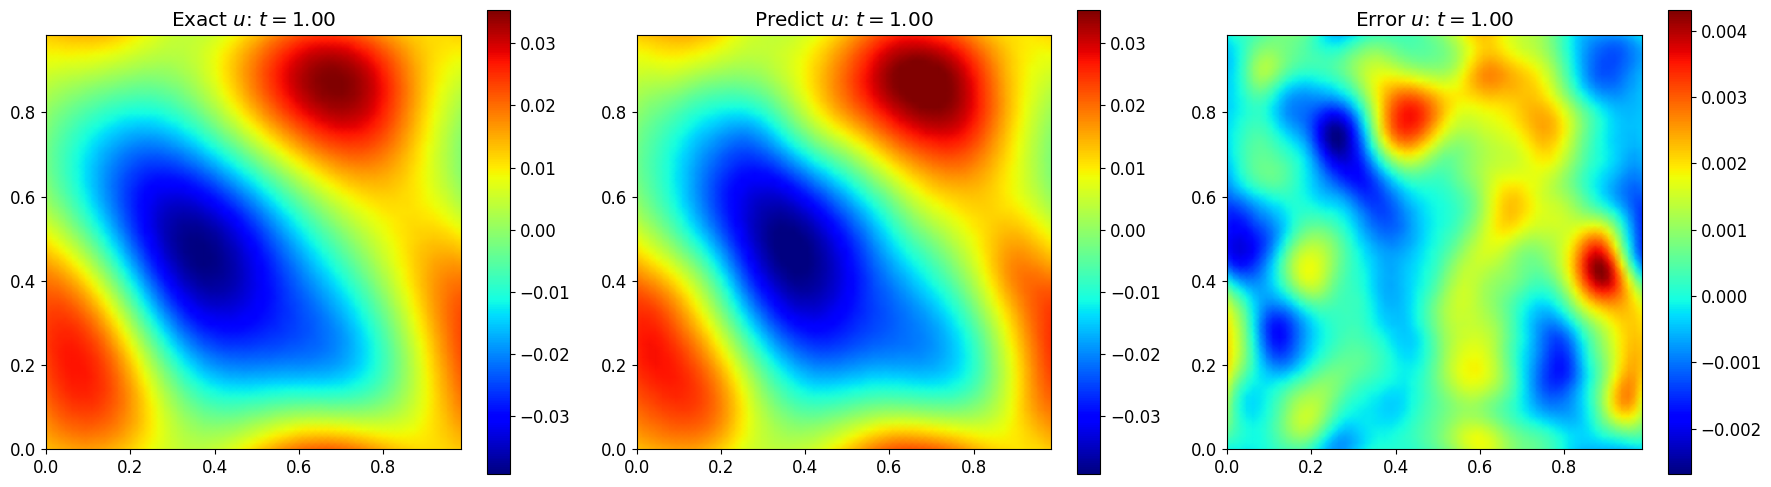

In [226]:
%matplotlib inline
key = 2
movie_name = f'Burgers2D_{key}.gif'
frame_basename = f'Burgers2D_{key}_frame'
frame_ext = 'jpg'
plot_title = "$u$"
field = 0
val_cbar_index = -1
err_cbar_index = -1
font_size = 12
remove_frames = True

generate_movie_2D(key, test_x, test_y, preds_y, 
                  plot_title=plot_title, 
                  field=field, 
                  val_cbar_index=val_cbar_index, 
                  err_cbar_index=err_cbar_index, 
                  movie_dir=movie_dir, 
                  movie_name=movie_name, 
                  frame_basename=frame_basename, 
                  frame_ext=frame_ext, 
                  remove_frames=remove_frames, 
                  font_size=font_size)


C:\Users\Sarry\AppData\Local\Temp\ipykernel_19248\1844917295.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


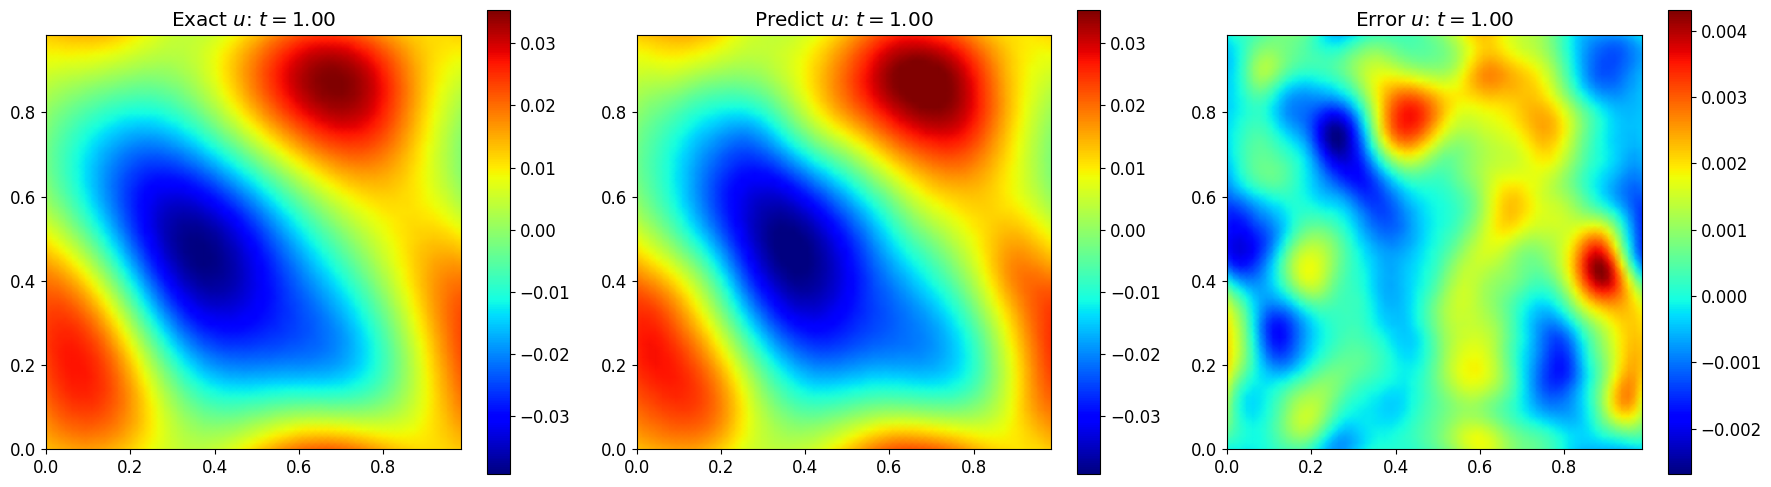

In [227]:
%matplotlib inline
key = 2
movie_name = f'Burgers2D_{key}.gif'
frame_basename = f'Burgers2D_{key}_frame'
frame_ext = 'jpg'
plot_title = "$u$"
field = 0
val_cbar_index = -1
err_cbar_index = -1
font_size = 12
remove_frames = True

generate_movie_2D(key, test_x, test_y, preds_y, 
                  plot_title=plot_title, 
                  field=field, 
                  val_cbar_index=val_cbar_index, 
                  err_cbar_index=err_cbar_index, 
                  movie_dir=movie_dir, 
                  movie_name=movie_name, 
                  frame_basename=frame_basename, 
                  frame_ext=frame_ext, 
                  remove_frames=remove_frames, 
                  font_size=font_size)


In [1]:
def plot_loss_line(l):
    # 输入一个loss矩阵，计算误差,l为一个二维矩阵
    y=np.array(l)
    # y=y[:,1]
    # y=y[3:]
    x=np.linspace(1,1+len(y),len(y))
    plt.plot(x,y/50)
    plt.xlabel(f'$iteration$')
    plt.ylabel(f'$loss$')
    plt.title(f'Burgers 2D Equation Loss')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
%matplotlib inline
# loss=loss_1+loss_2
# loss=np.array(loss)
# x=np.linspace(1,len(loss)+1,len(loss))
# y=np.log(loss[:,1])
# plt.plot(x,y)
plot_loss_line(loss_1)
# plot_loss_line(loss_2)

NameError: name 'loss_1' is not defined